# Neural network method for each parameter

### Nov. 28th, 2018

First, let me clarify that there are some machine learning-based articles about the camera calibration.
They include:
- Ahmed, M. T., Hemayed, E. E., & Farag, A. A. (1999). Neurocalibration: a neural network that can tell camera calibration parameters. In Computer Vision, 1999. The Proceedings of the Seventh IEEE International Conference on (Vol. 1, pp. 463-468). IEEE.
- Hold-Geoffroy, Y., Sunkavalli, K., Eisenmann, J., Fisher, M., Gambaretto, E., Hadap, S., & Lalonde, J. F. (2017). A Perceptual Measure for Deep Single Image Camera Calibration. arXiv preprint arXiv:1712.01259.
- Workman, S., Greenwell, C., Zhai, M., Baltenberger, R., & Jacobs, N. (2015, September). DEEPFOCAL: a method for direct focal length estimation. In Image Processing (ICIP), 2015 IEEE International Conference on (pp. 1369-1373). IEEE.

Especially, Hold-Geoffroy et al. (2017) uses **multiple heads** for estimating two parameters, each of which uses ``softmax`` activation function at its last layer to give the probability distribution in the 256 **discretized bins**.
We can adopt the same method, in the following ways:
- Neural network seems to work better on classification rather than regression.
- ``softmax`` is widely used in this part, so it is more reliable than my other definitions. In the same sense, let's use ``ReLU`` for the activation functions in the hidden layers.
- Such information with the probability distribution might be more beneficial for our parameter estimation, because it can give some error range of each parameter rather than just a single value.
- Estimation of the entire parameters may not be so beneficial since some parameters may never be tamed by collective fitting. We need to clarify which parameters can be tamed and which are not, at least.

Additional idea of sorting input parameters (pixel positions of plate fiducials) in different way --- from sorting with X-position to sorting (counter-)clockwise --- may be beneficial, but let's test the above idea first.

## $N_{\rm sample} = 10^4, \epsilon = 1\%$, $N_{\rm fid} = 40$, ordering with X-direction
### 1) Tc0

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

import os
import keras
from keras.models import Sequential,load_model
from keras.layers import (Dense, Activation,
                          LeakyReLU,PReLU,
                          Flatten, Conv1D,Conv2D,
                          Dropout, Reshape, 
                          UpSampling2D, BatchNormalization, 
                          GlobalAveragePooling1D,MaxPooling1D,MaxPooling2D)
from keras.optimizers import SGD
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf

Using TensorFlow backend.


In [4]:
# This is to read the data
Ninput = 40
fout = h5py.File("sample_1e4.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:],fout['Params'][:,0]
fout.close()

In [2]:
def MakeBin(arrInput,Nbins,xmin,xmax):
    arrOutput = []
    diff = (xmax-xmin)/Nbins
    for inp in arrInput:
        out = np.zeros(Nbins)
        indx = int(np.floor((inp-xmin)/diff))
        if indx == Nbins:
            indx -= 1
        out[indx] = 1
        arrOutput.append(out)
        
    print("Done making binning output in [%f, %f] with %d steps" % (xmin,xmax,Nbins),flush=True)
    return np.array(arrOutput)

In [5]:
binOut = MakeBin(outputs,256,-1,1)

Done making binning output in [-1.000000, 1.000000] with 256 steps


Since this is a **new** first time, let's get some experiments again.

Going back to the basic, let's use widely-used options now.
- Hidden layers
 + Activation function : ``relu``
- Last layer
 + Number of neurons : 256 (same to the output)
 + Activation function : ``softmax``
- Compile option
 + optimizer : ``adam``
 + loss : ``kullback_leibler_divergence``
 + metric : ``acc``
 
Now the question is the number of hidden layers and number of neurons for each hidden layer.
Check the single hidden layer first, with 256, 128, 80, 64, 32, 16 neurons.

In [ ]:
# single layer, 256 neurons
model = Sequential()

model.add(Dense(256, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc'])

hist256 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 128 neurons
model = Sequential()

model.add(Dense(128, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc'])

hist128 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 80 neurons
model = Sequential()

model.add(Dense(80, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc'])

hist80 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 64 neurons
model = Sequential()

model.add(Dense(64, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc'])

hist64 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 32 neurons
model = Sequential()

model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc'])

hist32 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

<Figure size 432x288 with 0 Axes>

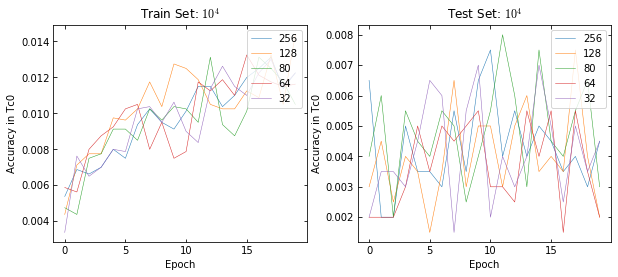

In [17]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(10,4))
axTrain,axTest = axs[0],axs[1]

axTrain.plot(hist256.history['acc'],lw=0.5,label="256")
axTrain.plot(hist128.history['acc'],lw=0.5,label="128")
axTrain.plot(hist80.history['acc'],lw=0.5,label="80")
axTrain.plot(hist64.history['acc'],lw=0.5,label="64")
axTrain.plot(hist32.history['acc'],lw=0.5,label="32")
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('Accuracy in Tc0')
axTrain.legend(loc='upper right')


axTest.plot(hist256.history['val_acc'],lw=0.5,label="256")
axTest.plot(hist128.history['val_acc'],lw=0.5,label="128")
axTest.plot(hist80.history['val_acc'],lw=0.5,label="80")
axTest.plot(hist64.history['val_acc'],lw=0.5,label="64")
axTest.plot(hist32.history['val_acc'],lw=0.5,label="32")

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('Accuracy in Tc0')
axTest.legend(loc='upper right')

Hmm.... the given ``accuracy`` is not that useful for our purpose.
Instead, let's define accuracy as (mean value of output array) - (mean value of input array).

In [3]:
import keras.backend as K

def probMeanErr(y_true,y_pred):
    arrX = K.variable(value=np.arange(256)/128.)
    y_true_avg = K.sum(y_true*arrX,axis=-1)
    y_pred_avg = K.sum(y_pred*arrX,axis=-1)
    return K.sqrt(K.mean(K.square(y_true_avg-y_pred_avg),axis=-1))

In [ ]:
# single layer, 256 neurons
model = Sequential()

model.add(Dense(256, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])

hist256 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 128 neurons
model = Sequential()

model.add(Dense(128, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])

hist128 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 64 neurons
model = Sequential()

model.add(Dense(64, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])

hist64 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

In [ ]:
# single layer, 32 neurons
model = Sequential()

model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])

hist32 = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)

<Figure size 432x288 with 0 Axes>

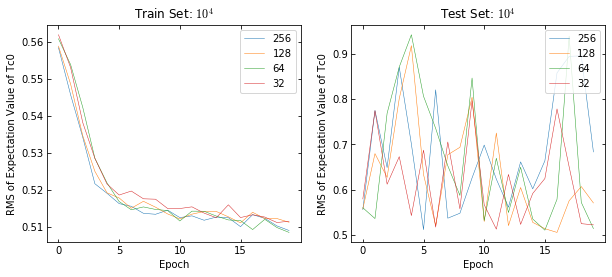

In [28]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(10,4))
axTrain,axTest = axs[0],axs[1]

axTrain.plot(hist256.history['probMeanErr'],lw=0.5,label="256")
axTrain.plot(hist128.history['probMeanErr'],lw=0.5,label="128")
axTrain.plot(hist64.history['probMeanErr'],lw=0.5,label="64")
axTrain.plot(hist32.history['probMeanErr'],lw=0.5,label="32")
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value of Tc0')
axTrain.legend(loc='upper right')


axTest.plot(hist256.history['val_probMeanErr'],lw=0.5,label="256")
axTest.plot(hist128.history['val_probMeanErr'],lw=0.5,label="128")
axTest.plot(hist64.history['val_probMeanErr'],lw=0.5,label="64")
axTest.plot(hist32.history['val_probMeanErr'],lw=0.5,label="32")

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value of Tc0')
axTest.legend(loc='upper right')

Seems like there is no big difference in number of neurons in the hidden layer.
By setting it as 32, check the performance of other parameters too.

In [29]:
# This is to read the data
Ninput = 40
fout = h5py.File("sample_1e4.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:],fout['Params'][:,:]
fout.close()

In [ ]:
arrName = ['Tc0','Tc1','Rc0','Rc1','Rc2','fc','kc0','kc1','kc2','kc3','kc4','cc0','cc1']
arrHist = []
for name,indx in zip(arrName,range(len(arrName))):
    binOut = MakeBin(outputs[:,indx],256,-1,1)
    
    model = Sequential()

    model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])
    
    hist = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)
    arrHist.append(hist)
    print("Done making %s" % (name),flush=True)

<Figure size 432x288 with 0 Axes>

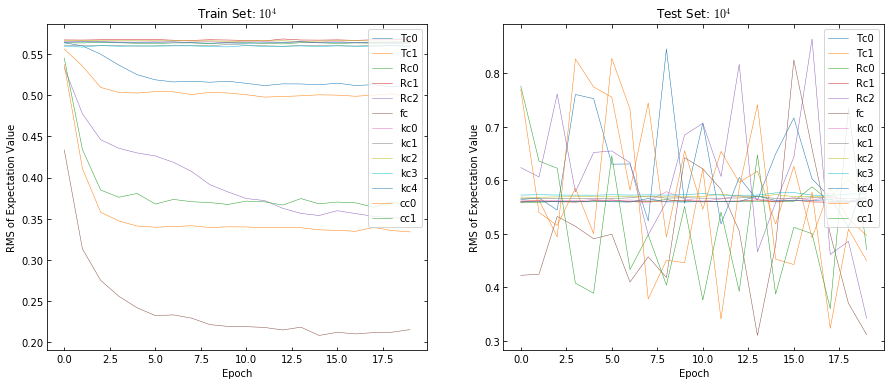

In [32]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(15,6))
axTrain,axTest = axs[0],axs[1]

for name,hist in zip(arrName,arrHist):
    axTrain.plot(hist.history['probMeanErr'],lw=0.5,label=name)
    axTest.plot(hist.history['val_probMeanErr'],lw=0.5,label=name)
    
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value')
axTrain.legend(loc='upper right')

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value')
axTest.legend(loc='upper right')

Probably the above figure just shows that
- fc, cc[] and Rc[3] (the largest part of rotation) can be constrained by neural network (probably usual least-square fitting can do it also)
- Tc[1,2] and Rc[1,2] (rest of the extrinsic parameters) can be marginally constrained by neural network
- kc[] cannot be constrained by neural network.

But before ending like this, let's try a bit more tests:
- change the order of input vectors (counter-clockwise)
- change the size of input vectors (40 --> 38)
- increase the number of input samples ($10^4 \to 10^5 \to ...$)

## $N_{\rm sample} = 10^4, \epsilon = 1\%$, $N_{\rm fid} = 38$, X-ordering

In [6]:
# This is to read the data
Ninput = 38
fout = h5py.File("sample_1e4.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:2*Ninput],fout['Params'][:,:]
fout.close()

In [ ]:
arrName = ['Tc0','Tc1','Rc0','Rc1','Rc2','fc','kc0','kc1','kc2','kc3','kc4','cc0','cc1']
arrHist = []
for name,indx in zip(arrName,range(len(arrName))):
    binOut = MakeBin(outputs[:,indx],256,-1,1)
    
    model = Sequential()

    model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])
    
    hist = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)
    arrHist.append(hist)
    print("Done making %s" % (name),flush=True)

<Figure size 432x288 with 0 Axes>

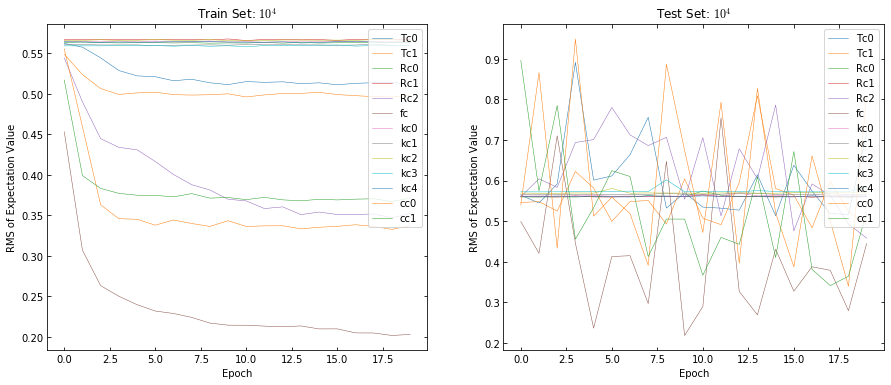

In [10]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(15,6))
axTrain,axTest = axs[0],axs[1]

for name,hist in zip(arrName,arrHist):
    axTrain.plot(hist.history['probMeanErr'],lw=0.5,label=name)
    axTest.plot(hist.history['val_probMeanErr'],lw=0.5,label=name)
    
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value')
axTrain.legend(loc='upper right')

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value')
axTest.legend(loc='upper right')

## $N_{\rm sample} = 10^4, \epsilon = 1\%, N_{\rm fid} = 40$, counterclockwise

In [11]:
# This is to read the data
WIDTH,HEIGHT = 2448, 2050

Ninput = 40
fout = h5py.File("sample_1e4.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:2*Ninput],fout['Params'][:,:]
fout.close()

newInput = []
for inp in inputs:
    realInp = inp[inp >= 0].reshape(-1,2)
    realInp = [[data[0],data[1],np.arctan2(data[1]-0.5*HEIGHT,data[0]-0.5*WIDTH)] for data in realInp]
    realInp = np.array(sorted(realInp,key=itemgetter(2)))[:,:2].flatten()
    #print(realInp,flush=True)
    newInput.append(np.concatenate((realInp,-1*np.ones(2*Ninput-len(realInp)))))
    
inputs = np.array(newInput)

In [ ]:
arrName = ['Tc0','Tc1','Rc0','Rc1','Rc2','fc','kc0','kc1','kc2','kc3','kc4','cc0','cc1']
arrHist = []
for name,indx in zip(arrName,range(len(arrName))):
    binOut = MakeBin(outputs[:,indx],256,-1,1)
    
    model = Sequential()

    model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])
    
    hist = model.fit(inputs,binOut,epochs=20,verbose=0,batch_size=5,validation_split=0.2)
    arrHist.append(hist)
    print("Done making %s" % (name),flush=True)

<Figure size 432x288 with 0 Axes>

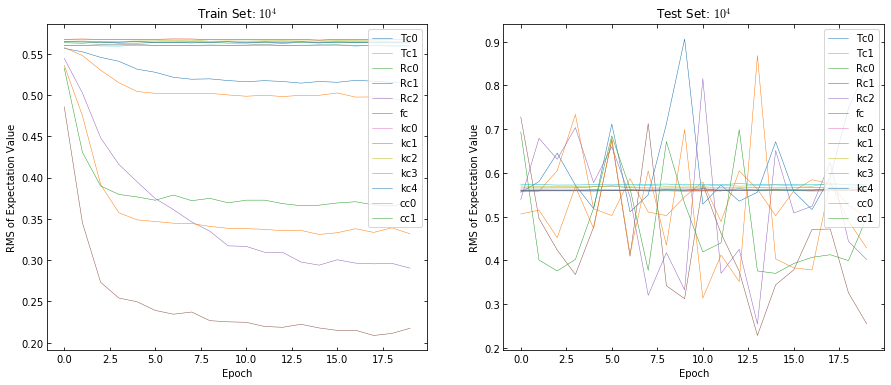

In [13]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(15,6))
axTrain,axTest = axs[0],axs[1]

for name,hist in zip(arrName,arrHist):
    axTrain.plot(hist.history['probMeanErr'],lw=0.5,label=name)
    axTest.plot(hist.history['val_probMeanErr'],lw=0.5,label=name)
    
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value')
axTrain.legend(loc='upper right')

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value')
axTest.legend(loc='upper right')

## $N_{\rm sample} = 10^4, \epsilon = 1\%, N_{\rm fid} = 38$, counterclockwise

In [15]:
# This is to read the data
WIDTH,HEIGHT = 2448, 2050

Ninput = 38
fout = h5py.File("sample_1e4.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:2*Ninput],fout['Params'][:,:]
fout.close()

newInput = []
for inp in inputs:
    realInp = inp[inp >= 0].reshape(-1,2)
    realInp = [[data[0],data[1],np.arctan2(data[1]-0.5*HEIGHT,data[0]-0.5*WIDTH)] for data in realInp]
    realInp = np.array(sorted(realInp,key=itemgetter(2)))[:,:2].flatten()
    #print(realInp,flush=True)
    newInput.append(np.concatenate((realInp,-1*np.ones(2*Ninput-len(realInp)))))
    
inputs = np.array(newInput)

In [ ]:
arrName = ['Tc0','Tc1','Rc0','Rc1','Rc2','fc','kc0','kc1','kc2','kc3','kc4','cc0','cc1']
arrHist = []
for name,indx in zip(arrName,range(len(arrName))):
    binOut = MakeBin(outputs[:,indx],256,-1,1)
    
    model = Sequential()

    model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])
    
    hist = model.fit(inputs,binOut,epochs=20,verbose=0,batch_size=5,validation_split=0.2)
    arrHist.append(hist)
    print("Done making %s" % (name),flush=True)

<Figure size 432x288 with 0 Axes>

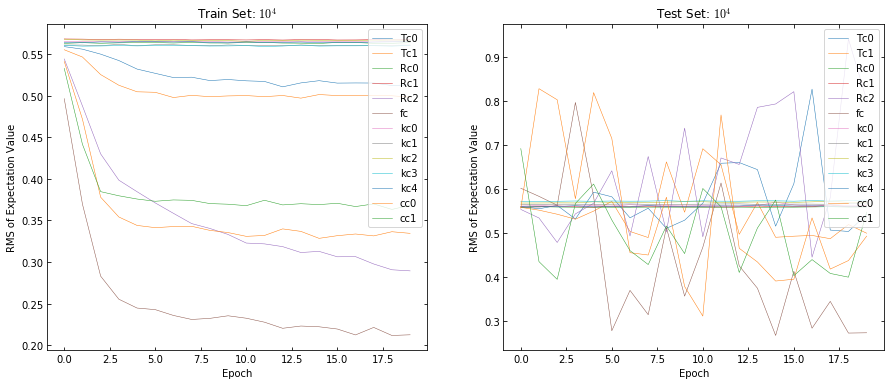

In [17]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(15,6))
axTrain,axTest = axs[0],axs[1]

for name,hist in zip(arrName,arrHist):
    axTrain.plot(hist.history['probMeanErr'],lw=0.5,label=name)
    axTest.plot(hist.history['val_probMeanErr'],lw=0.5,label=name)
    
axTrain.set_title(r'Train Set: $10^4$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value')
axTrain.legend(loc='upper right')

axTest.set_title(r'Test Set: $10^4$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value')
axTest.legend(loc='upper right')

While there is not so much difference between X-ordering and counterclockwise in general, the expectation power of Rc[3] parameters is greatly increased in case of counterclockwise ordering.
(You can see that it may even be better with more epochs!)
Probably the counterclockwise ordering makes the estimation of camera rotation a bit easier.

Let's use this setting ($N_{\rm fid} = 38$, counterclockwise ordering) as default, and try increasing the number of samples.

## $N_{\rm sample} = 10^5, \epsilon = 1\%, N_{\rm fid} = 38$, counterclockwise ordering

In [18]:
# This is to read the data
WIDTH,HEIGHT = 2448, 2050

Ninput = 38
fout = h5py.File("sample_1e5.hdf5","r")
inputs,outputs = fout['PixFiducial'][:,:2*Ninput],fout['Params'][:,:]
fout.close()

newInput = []
for inp in inputs:
    realInp = inp[inp >= 0].reshape(-1,2)
    realInp = [[data[0],data[1],np.arctan2(data[1]-0.5*HEIGHT,data[0]-0.5*WIDTH)] for data in realInp]
    realInp = np.array(sorted(realInp,key=itemgetter(2)))[:,:2].flatten()
    #print(realInp,flush=True)
    newInput.append(np.concatenate((realInp,-1*np.ones(2*Ninput-len(realInp)))))
    
inputs = np.array(newInput)

In [ ]:
arrName = ['Tc0','Tc1','Rc0','Rc1','Rc2','fc','kc0','kc1','kc2','kc3','kc4','cc0','cc1']
arrHist = []
for name,indx in zip(arrName,range(len(arrName))):
    binOut = MakeBin(outputs[:,indx],256,-1,1)
    
    model = Sequential()

    model.add(Dense(32, input_shape=(2*Ninput,),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['acc',probMeanErr])
    
    hist = model.fit(inputs,binOut,epochs=20,verbose=1,batch_size=5,validation_split=0.2)
    arrHist.append(hist)
    print("Done making %s" % (name),flush=True)

The above part was done by additional Python code --- it took ~6 hours to run everything.

The fitting log is written in ``NN_training_1e5.log``.
I actually tried to save them as separate HDF5 file, but it failed somehow, so let's just parse the given log to draw results.

In [3]:
def ParseHistoryLog(filename):
    arrName,arrTrainRMS,arrTestRMS = [],[],[]
    tmpTrainRMS,tmpTestRMS = [],[]
    
    fp = open(filename,"r")
    for line in fp:
        strs = line.split()
        if len(strs) == 3:
            arrName.append(strs[2])
            
            arrTrainRMS.append(tmpTrainRMS)
            arrTestRMS.append(tmpTestRMS)
            
            tmpTrainRMS,tmpTestRMS = [],[]
        elif len(strs) == 20:
            tmpTrainRMS.append(np.float(strs[10]))
            tmpTestRMS.append(np.float(strs[19]))
            
    fp.close()
            
    return arrName,np.array(arrTrainRMS),np.array(arrTestRMS)

<Figure size 432x288 with 0 Axes>

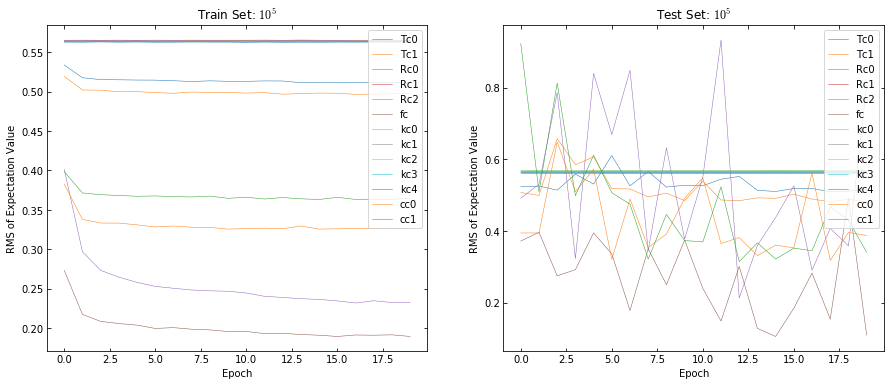

In [6]:
%matplotlib inline

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(15,6))
axTrain,axTest = axs[0],axs[1]

arrName,arrTrain,arrTest = ParseHistoryLog("model/NN_training_1e5.log")
for name,train,test in zip(arrName,arrTrain,arrTest):
    axTrain.plot(train,lw=0.5,label=name)
    axTest.plot(test,lw=0.5,label=name)
    
axTrain.set_title(r'Train Set: $10^5$')
axTrain.set_xlabel('Epoch')
axTrain.set_ylabel('RMS of Expectation Value')
axTrain.legend(loc='upper right')

axTest.set_title(r'Test Set: $10^5$')
axTest.set_xlabel('Epoch')
axTest.set_ylabel('RMS of Expectation Value')
axTest.legend(loc='upper right')

So increasing the number of samples can further increase the estimation power of **fc** and **Rc[3]** (and see, there still seems to be a chance that they can be even better with more samples and training epochs!)

However, increasing the number of samples does not affect the estimation power of other parameters.
This again may show the limitation of this method.
Let's wrap up this part now, and try a new way of least-square fitting next.